# Initialise 

In [71]:
import sys
import surprise as sp
import numpy as np
import pandas as pd
import time
import datetime
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from tabulate import tabulate
from recommender.algorithms.models import RecommenderModel
from recommender import (SVDModel, PopularityModel, RandomModel,
                    RecommenderData, get_movielens_data)
from recommender.algorithms.models import CoffeeModel
from recommender.evaluation import evaluation_engine as ee
from recommender.tools.preprocessing import filter_sessions_by_length
from recommender.evaluation.plotting import show_hit_rates, show_precision_recall, show_ranking, _plot_pair

from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

In [60]:
DATA_NAME = 'ml-1m'
DATA_FILE = None
SESS_SIZE = 20

## Prepare data

In [61]:
ml_data = get_movielens_data(local_file=DATA_FILE, get_genres=False)

In [62]:
ml_data = filter_sessions_by_length(ml_data, min_session_length=SESS_SIZE)
data_model = RecommenderData(ml_data, 'userid', 'movieid', 'rating', seed = 0)
data_model.name = DATA_NAME

In [63]:
data_model.get_configuration()

{'random_holdout': False,
 'warm_start': True,
 'test_fold': 5,
 'holdout_size': 3,
 'test_sample': None,
 'negative_prediction': False,
 'permute_tops': False,
 'shuffle_data': False,
 'test_ratio': 0.2}

In [64]:
# data parsing
parsed_data = pd.read_csv("winemag-data-130k-v2.csv")
filtered_data = parsed_data[['country','province','region_1','variety','price','taster_name','points']]
cleaned_data = filtered_data.rename(columns={'region_1': 'region'}).dropna(subset=['country','province','region','variety','taster_name','points'])

# group all wines from a region that have the same variety, assign mean price
wines_all = cleaned_data.groupby(['country', 'province', 'region', 'variety']).agg({'price': 'mean'}).reset_index()
wines_all = wines_all.assign(id=pd.Series(range(1, wines_all.shape[0]+1), dtype=int, index=wines_all.index))
wines_all = wines_all[['id', 'country', 'province', 'region', 'variety', 'price']]

users_all = cleaned_data.groupby('taster_name').count().reset_index()[['taster_name']]
users_all = users_all.assign(id=pd.Series(range(1, users_all.shape[0]+1), dtype=int, index=users_all.index))

# link ratings to wines and users via id
wine_id_translator = {(row['country'], row['province'], row['region'], row['variety']): row['id'] for index, row in wines_all.iterrows()}
user_id_translator = {row['taster_name']: row['id'] for index, row in users_all.iterrows()}
def get_wine_id_series(data_frame):
    return pd.Series((wine_id_translator[(row['country'], row['province'], row['region'], row['variety'])] for _, row in data_frame.iterrows()), index=data_frame.index)
def get_user_id_series(data_frame):
    return pd.Series((user_id_translator[row['taster_name']] for _, row in data_frame.iterrows()), index=data_frame.index)

# aggregate average points of all ratings from a user for a wine
ratings_all = cleaned_data.assign(wine_id=get_wine_id_series, user_id=get_user_id_series)[['taster_name', 'user_id', 'wine_id', 'points']].groupby(['user_id', 'taster_name', 'wine_id']).mean().reset_index()

# only include wines that have 3 or more ratings
most_rated_wines = list(ratings_all.groupby(['wine_id']).count()[lambda x: x['points'] >= 3].reset_index()['wine_id'].values)

ratings = ratings_all.loc[ratings_all['wine_id'].isin(most_rated_wines)].astype({'wine_id': int, 'user_id': int}).reset_index(drop=True)
wines = wines_all.loc[wines_all['id'].isin(most_rated_wines)].astype({'id': int}).reset_index(drop=True)
users = users_all.loc[users_all['id'].isin(ratings['user_id'].values)].astype({'id': int}).reset_index(drop=True)

In [65]:
wines.head()

,id,country,province,region,variety,price
0,739,Canada,Ontario,Niagara Peninsula,Riesling,42.423077
1,741,Canada,Ontario,Niagara Peninsula,Vidal Blanc,62.615385
2,757,France,Alsace,Alsace,Gewürztraminer,34.206897
3,760,France,Alsace,Alsace,Pinot Blanc,17.622047
4,778,France,Alsace,Crémant d'Alsace,Sparkling Blend,24.886256


In [66]:
users.head()

,taster_name,id
0,Alexander Peartree,1
1,Anna Lee C. Iijima,2
2,Anne Krebiehl MW,3
3,Carrie Dykes,4
4,Christina Pickard,5


In [67]:
ratings.head()

,user_id,taster_name,wine_id,points
0,1,Alexander Peartree,5069,87.666667
1,1,Alexander Peartree,5737,89.000000
2,1,Alexander Peartree,5738,86.750000
3,1,Alexander Peartree,5741,86.250000
4,1,Alexander Peartree,5743,88.000000


In [68]:
classes = (SVD, NMF, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline,
           CoClustering, BaselineOnly, NormalPredictor, SVDpp)

## Prepare models

In [6]:
svd = SVDModel(data_model)
popular = PopularityModel(data_model)
random = RandomModel(data_model, seed=0)
coffee = CoffeeModel(data_model)
coffee.method = 'Hybrid'
#pmf = ProbabilisticMF(data_model)

In [7]:
coffee.flattener = [3, 4] 

In [8]:
models = [svd, coffee, popular, random]
model_names = [model.method for model in models]
model_names

['PureSVD', 'Hybrid', 'MP', 'RND']

In [9]:
for model in models:
    model.switch_positive = 4

In [38]:
# Collaborative Filtering

def predict_cf(ratings, taster_name, wine_id):
    is_target = (ratings['taster_name'] == taster_name) & (ratings['wine_id'] == wine_id)
    target = ratings[is_target].iloc[0]
    
    train_set = sp.Dataset.load_from_df(
        ratings[~is_target][['user_id', 'wine_id', 'points']], 
        sp.Reader(rating_scale=(0, 100))
    ).build_full_trainset()

    algo = sp.KNNBasic(verbose=False)
    algo.fit(train_set)
    prediction = algo.predict(target['user_id'], target['wine_id'], verbose=False)
    return prediction.est, prediction.est - target['points'], target['points']

In [39]:
# Content-Based

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

def predict_cn(ratings, wines, taster_name, wine_id):
    user_ratings = ratings[ratings['taster_name'] == taster_name].join(wines.set_index('id'), on='wine_id')
    is_target = (user_ratings['wine_id'] == wine_id)
    
    features = pd.get_dummies(user_ratings.drop(columns=['points']))
    train_features = features[~is_target]
    target_features = features[is_target]
    
    encoder = LabelEncoder()
    train_labels = encoder.fit_transform(user_ratings[~is_target]['points'])
    target_label = user_ratings[is_target]['points'].iloc[0]

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(train_features, train_labels)
    prediction = encoder.inverse_transform(clf.predict(target_features))[0]
    return prediction, prediction - target_label, target_label

In [40]:
def test_classifier(taster_name, wine_id):
    pred_cf, error_cf, truth = predict_cf(ratings, taster_name, wine_id)
    pred_cn, error_cn, truth = predict_cn(ratings, wines, taster_name, wine_id)
    print("Results for {} on wine with id {}:".format(taster_name, wine_id))
    print("Collaborative Filtering: \t prediction: {:.5f} \t error: {:.5f}".format(pred_cf, error_cf))
    print("Content-Based: \t\t\t prediction: {:.5f} \t error: {:.5f}".format(pred_cn, error_cn))

In [41]:
def predict_weighted(ratings, wines, taster_name, wine_id):
    prediction_cf, _, truth = predict_cf(ratings, taster_name, wine_id)
    prediction_cn, _, truth = predict_cn(ratings, wines, taster_name, wine_id)
    
    # Weights can be chosen differently, depending on 
    # the (assumed) quality of the recommenders
    prediction = 0.5 * prediction_cf + 0.5 * prediction_cn
    error = prediction - truth
    return prediction, error, truth


pred_weighted, error_weighted, truth = predict_weighted(ratings, wines, taster_name='Anna Lee C. Iijima', wine_id=741)
print("Weighted Hybrid: \t prediction: {:.5f} \t error: {:.5f}".format(pred_weighted, error_weighted))

Weighted Hybrid: 	 prediction: 89.57780 	 error: -0.08887


In [44]:
ratings_matrix = ratings.pivot(index='wine_id', columns='user_id', values='points')
# NaN can be filld with the mean of either 
# the user's or the item's ratings.
ratings_matrix = ratings_matrix.fillna(ratings_matrix.mean())

from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(ratings_matrix)
wines_plus = pd.concat([wines, pd.DataFrame(W)], axis=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [45]:
def predict_switching(ratings, wines, taster_name, wine_id):
    # The selection of the recommender is done based on the 
    # number of ratings that have been recorded for the item.
    num_ratings = len(ratings[ratings['wine_id'] == wine_id])
    if num_ratings > 3:
        print('Using Collaborative Filtering recommender')
        return predict_cf(ratings, taster_name, wine_id)
    else:
        print('Using Content-Based recommender')
        return predict_cn(ratings, wines, taster_name, wine_id)


## Set evaluation parameters

In [10]:
metrics = ['ranking', 'relevance', 'experience']
topk_list = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100]
test_samples = [0, -1]
folds = [1, 2, 3, 4, 5]

In [11]:
data_model.holdout_size = 10
data_model.random_holdout = True

# Run experiments

In [12]:
result = {}
for test_sample in test_samples:
    data_model.test_sample = test_sample
    result[test_sample] = ee.run_cv_experiment(models,
                                               folds,
                                               metrics,
                                               fold_experiment=ee.topk_test,
                                               topk_list=topk_list)

Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


23 unique movieid's within 27 testset interactions were filtered. Reason: not in the training data.
1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
1 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 803312 events in the training and 12070 events in the holdout.
PureSVD training time: 0.130s
Hybrid training time: 1.287s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


47 unique movieid's within 56 testset interactions were filtered. Reason: not in the training data.
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 792890 events in the training and 12060 events in the holdout.
PureSVD training time: 0.122s
Hybrid training time: 0.649s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


16 unique movieid's within 18 testset interactions were filtered. Reason: not in the training data.
4 unique movieid's within 4 holdout interactions were filtered. Reason: not in the training data.
4 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
4 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 808443 events in the training and 12040 events in the holdout.
PureSVD training time: 0.137s
Hybrid training time: 0.894s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


28 unique movieid's within 39 testset interactions were filtered. Reason: not in the training data.
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 788733 events in the training and 12060 events in the holdout.
PureSVD training time: 0.122s
Hybrid training time: 0.946s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


18 unique movieid's within 25 testset interactions were filtered. Reason: not in the training data.
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 807458 events in the training and 12060 events in the holdout.
PureSVD training time: 0.126s
Hybrid training time: 0.913s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
1 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 803312 events in the training and 12070 events in the holdout.
PureSVD training time: 0.134s
Hybrid training time: 0.989s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


1 unique movieid's within 1 testset interactions were filtered. Reason: not in the training data.
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
1 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 792890 events in the training and 12060 events in the holdout.
PureSVD training time: 0.108s
Hybrid training time: 1.211s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


1 unique movieid's within 1 testset interactions were filtered. Reason: not in the training data.
4 unique movieid's within 4 holdout interactions were filtered. Reason: not in the training data.
4 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
1 userid's were filtered out from holdout. Reason: inconsistent with testset.
4 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 808443 events in the training and 12030 events in the holdout.
PureSVD training time: 0.107s
Hybrid training time: 0.851s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 788733 events in the training and 12060 events in the holdout.
PureSVD training time: 0.110s
Hybrid training time: 0.818s
Preparing data...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/recommender-0.2.1-py3.8.egg/recommender/algorithms/data.py:16: FutureWarning: is_copy is deprecated and will be removed in a future version. 'take' always returns a copy, so there is no need to specify this.


2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 807458 events in the training and 12060 events in the holdout.
PureSVD training time: 0.112s
Hybrid training time: 0.940s


In [13]:
test_sample = 0

In [14]:
scores = result[test_sample].mean(axis=0, level=['top-n', 'model'])
deviation = result[test_sample].std(axis=0, level=['top-n', 'model'])

In [15]:
scores['ranking'].unstack('model')

metric      nDCG                                    nDCL                      \
model     Hybrid        MP   PureSVD       RND    Hybrid        MP   PureSVD   
top-n                                                                          
1       0.069047  0.034049  0.077220  0.000463  0.019111  0.021976  0.026973   
2       0.098975  0.049284  0.111342  0.000805  0.029356  0.031109  0.040239   
3       0.117406  0.057795  0.132601  0.000989  0.038635  0.037549  0.051971   
5       0.142477  0.070335  0.159641  0.001398  0.050379  0.048499  0.069481   
10      0.178305  0.091356  0.197528  0.002269  0.073676  0.064922  0.101178   
15      0.198951  0.105611  0.219348  0.002940  0.089729  0.077387  0.122217   
20      0.214130  0.116623  0.234971  0.003573  0.103431  0.086674  0.139544   
30      0.235511  0.130844  0.256997  0.004453  0.125621  0.101282  0.166981   
50      0.262716  0.151501  0.284766  0.006308  0.157187  0.125126  0.205027   
70      0.280261  0.164905  0.302296  0.007902  0.180260  0.143222  0.230614   
100     0.297538  0.180364  0.319825  0.010240  0.207401  0.165874  0.262407   

metric            
model        RND  
top-n             
1       0.001412  
2       0.001739  
3       0.002081  
5       0.002621  
10      0.004211  
15      0.005838  
20      0.006509  
30      0.008315  
50      0.011740  
70      0.014341  
100     0.018518

# Visualize results

In [16]:
ERR_ALPHA = 0.1

## Predictions for "known" user

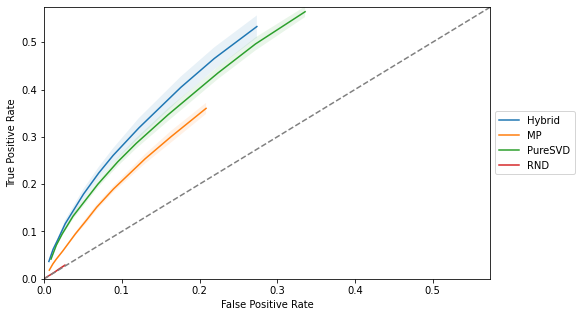

In [17]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

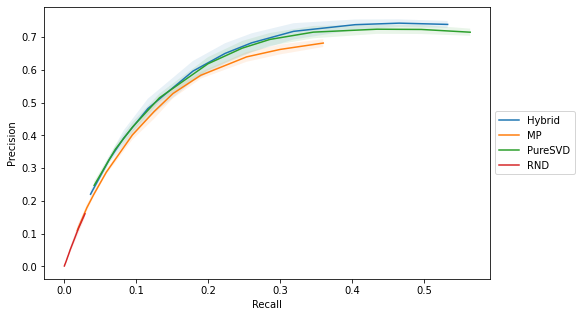

In [18]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

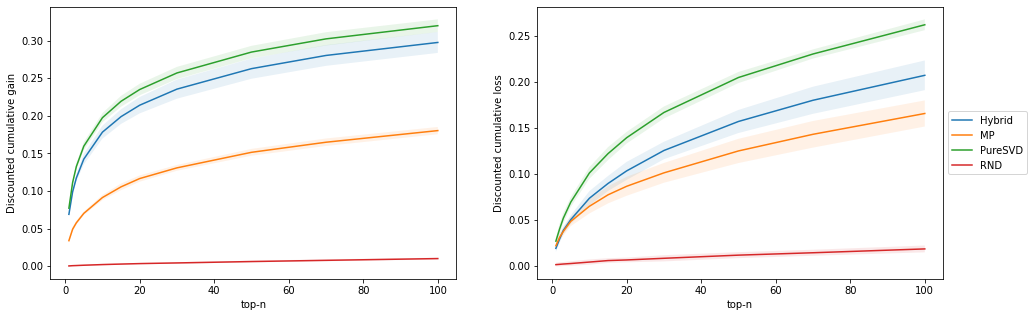

In [19]:
def show_rankings(all_scores, **kwargs):
    scores = all_scores['ranking'] if 'ranking' in all_scores else all_scores
    keys = ['nDCG', 'nDCL']
    kwargs['titles'] = ['Discounted cumulative gain', 'Discounted cumulative loss']
    kwargs['errors'] = kwargs['errors']['ranking'] if kwargs.get('errors', None) is not None else None
    _plot_pair(scores, keys, **kwargs)
show_rankings(scores, errors=deviation, err_alpha=ERR_ALPHA)

## Predictions from single negative feedback

In [20]:
test_sample = -1

In [21]:
scores = result[test_sample].mean(axis=0, level=['top-n', 'model'])
deviation = result[test_sample].std(axis=0, level=['top-n', 'model'])

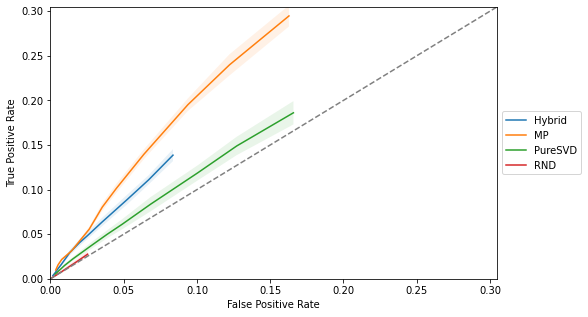

In [22]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

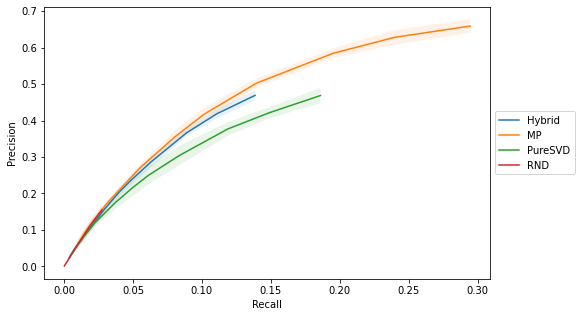

In [23]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

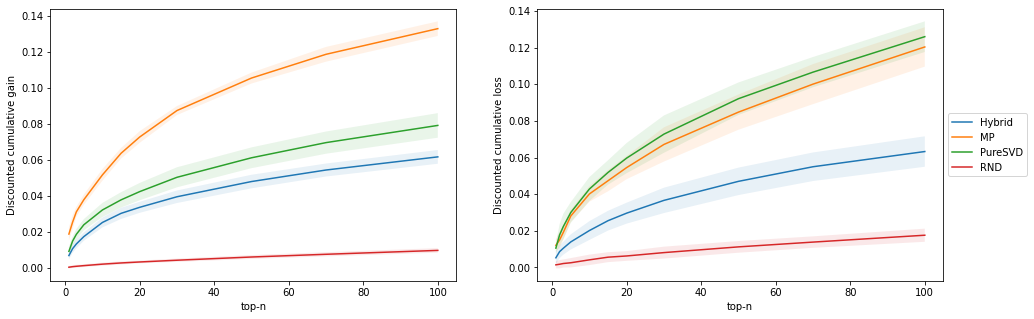

In [24]:
def show_rankings(all_scores, **kwargs):
    scores = all_scores['ranking'] if 'ranking' in all_scores else all_scores
    keys = ['nDCG', 'nDCL']
    kwargs['titles'] = ['Discounted cumulative gain', 'Discounted cumulative loss']
    kwargs['errors'] = kwargs['errors']['ranking'] if kwargs.get('errors', None) is not None else None
    _plot_pair(scores, keys, **kwargs)
show_rankings(scores, errors=deviation, err_alpha=ERR_ALPHA)

# Comparing the algorithms

In [25]:
scores = result[test_sample].mean(axis=0, level=['top-n', 'model'])
scores.xs('recall', level='metric', axis=1).unstack('model')

type  relevance                              
model    Hybrid        MP   PureSVD       RND
top-n                                        
1      0.003664  0.009799  0.005206  0.000241
2      0.006989  0.015478  0.010372  0.000513
3      0.009892  0.021689  0.014889  0.000752
5      0.015585  0.031350  0.022369  0.001338
10     0.029520  0.055598  0.037226  0.002828
15     0.040129  0.080349  0.049797  0.004327
20     0.048084  0.101492  0.061208  0.005597
30     0.063531  0.139568  0.083621  0.008190
50     0.088879  0.195207  0.118801  0.014028
70     0.110936  0.239909  0.148911  0.019190
100    0.138606  0.294662  0.186073  0.027591

In [46]:
test_classifier(taster_name='Anna Lee C. Iijima', wine_id=741)

Results for Anna Lee C. Iijima on wine with id 741:
Collaborative Filtering: 	 prediction: 89.65560 	 error: -0.01107
Content-Based: 			 prediction: 89.50000 	 error: -0.16667


In [49]:
test_classifier(taster_name='Virginie Boone', wine_id=4147)

Results for Virginie Boone on wine with id 4147:
Collaborative Filtering: 	 prediction: 87.93883 	 error: 2.83883
Content-Based: 			 prediction: 85.50000 	 error: 0.40000


In [50]:
pred_weighted, error_weighted, truth = predict_cn(ratings, wines_plus, taster_name='Anna Lee C. Iijima', wine_id=741)
print("Weighted Hybrid: \t prediction: {:.5f} \t error: {:.5f}".format(pred_weighted, error_weighted))

Weighted Hybrid: 	 prediction: 89.50000 	 error: -0.16667


In [51]:
pred, error, truth = predict_switching(ratings, wines, taster_name='Anna Lee C. Iijima', wine_id=741)
print("Switching Hybrid: \t prediction: {:.5f} \t error: {:.5f}".format(pred, error))

Using Collaborative Filtering recommender
Switching Hybrid: 	 prediction: 89.65560 	 error: -0.01107


In [52]:
pred, error, truth = predict_switching(ratings, wines, taster_name='Virginie Boone', wine_id=4147)
print("Switching Hybrid: \t prediction: {:.5f} \t error: {:.5f}".format(pred, error))

Using Content-Based recommender
Switching Hybrid: 	 prediction: 85.50000 	 error: 0.40000


In [69]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9364  0.9305  0.9298  0.9313  0.9499  0.9355  0.0075  
MAE (testset)     0.7391  0.7339  0.7329  0.7325  0.7497  0.7376  0.0065  
Fit time          4.03    4.17    4.25    3.88    4.12    4.09    0.12    
Test time         0.10    0.14    0.11    0.11    0.19    0.13    0.03    


{'test_rmse': array([0.93636035, 0.93047172, 0.92976903, 0.93125976, 0.94986429]),
 'test_mae': array([0.73905804, 0.73393413, 0.7329322 , 0.73248981, 0.74967861]),
 'fit_time': (4.029691934585571,
  4.166784048080444,
  4.246514320373535,
  3.884438991546631,
  4.115469694137573),
 'test_time': (0.10261416435241699,
  0.14330387115478516,
  0.10753178596496582,
  0.10622000694274902,
  0.18938994407653809)}

In [77]:
stable = ''
LINK = {'SVD':  'SVD' ,
        'SVDpp':  'SVD++' ,
        'NMF':  'NMF' ,
        'SlopeOne':  'Slope One' ,
        'KNNBasic':  'k-NN' ,
        'KNNWithMeans':  'Centered k-NN' ,
        'KNNBaseline':  'k-NN Baseline' ,
        'CoClustering':  'Co-Clustering' ,
        'BaselineOnly':  'Baseline' ,
        'NormalPredictor':  'Random' ,
        'ml-100k':  'Movielens 100k' ,
        'ml-1m':  'Movielens 1M' ,
        }
print(LINK)

{'SVD': 'SVD', 'SVDpp': 'SVD++', 'NMF': 'NMF', 'SlopeOne': 'Slope One', 'KNNBasic': 'k-NN', 'KNNWithMeans': 'Centered k-NN', 'KNNBaseline': 'k-NN Baseline', 'CoClustering': 'Co-Clustering', 'BaselineOnly': 'Baseline', 'NormalPredictor': 'Random', 'ml-100k': 'Movielens 100k', 'ml-1m': 'Movielens 1M'}


In [78]:
np.random.seed(0)
random.seed(0)

dataset = 'ml-100k'
data = Dataset.load_builtin(dataset)
kf = KFold(random_state=0)  # folds will be the same for all algorithms.

table = []
for klass in classes:
    start = time.time()
    out = cross_validate(klass(), data, ['rmse', 'mae'], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    link = LINK[klass.__name__]
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))

    new_line = [link, mean_rmse, mean_mae, cv_time]
    print(tabulate([new_line], tablefmt="pipe"))  # print current algo perf
    table.append(new_line)

header = [LINK[dataset],
          'RMSE',
          'MAE',
          'Time'
          ]
print(tabulate(table, header, tablefmt="pipe"))

|:----|------:|------:|:--------|
| SVD | 0.936 | 0.738 | 0:00:21 |
|:------|------:|------:|:--------|
| SVD++ | 0.922 | 0.723 | 0:13:07 |
|:----|------:|------:|:--------|
| NMF | 0.964 | 0.758 | 0:00:23 |
|:----------|------:|------:|:--------|
| Slope One | 0.946 | 0.743 | 0:00:16 |
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
|:-----|-----:|------:|:--------|
| k-NN | 0.98 | 0.774 | 0:00:14 |
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simila